# Multi class Random Forest modelling using number of selected plants per auction bins as the class to be predicted

### Import libraries and load data

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
%matplotlib inline
import seaborn as sns
import plotly.express as px
warnings.simplefilter(action='ignore', category=FutureWarning)
print('x' in np.arange(5))   #returns False, without Warning

False


In [10]:
##Importing data and creating dataframe 
df = pd.read_csv('firstout.csv')
df.head()

,Unnamed: 0,id,plant,size,number,auction,capacity,physical_guarantee,sold_lots,source,...,gkf,fdi,primary_energy_consumption,g,exch,inv_US$_billion,state,inv_size,physical_guarantee_size,distance_from_last_auction
0,0,1,UHE Foz do Rio Claro,0.091,11,Leilão 2/2005,68.4,41.0,41.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.120104543,GO,10918594.82,3.727273,0.798005
1,1,2,UHE São José,0.091,11,Leilão 2/2005,51.0,30.4,30.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.08931406,RS,8119460.00,2.763636,0.798005
2,2,3,UHE Passo São João,0.091,11,Leilão 2/2005,77.0,39.0,37.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.114362101,RS,10396554.64,3.545455,0.798005
3,3,4,UHE Simplício,0.091,11,Leilão 2/2005,337.7,191.3,185.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.616054447,RJ,56004949.73,17.390909,0.798005
4,4,5,UHE Retiro Baixo,0.091,11,Leilão 2/2005,82.0,38.5,36.0,hydro,...,17.204883,1.733901,8.86,84956.3,2.3399,0.112149186,MG,10195380.55,3.500000,0.798005


In [11]:
#Retrieving keys
df.keys()

Index(['Unnamed: 0', 'id', 'plant', 'size', 'number', 'auction', 'capacity',
       'physical_guarantee', 'sold_lots', 'source', 'company_consortium',
       'year', 'price_US$', 'inv_US$', 'gdp_growth', 'risk_embi', 'gkf', 'fdi',
       'primary_energy_consumption', 'g', 'exch', 'inv_US$_billion', 'state',
       'inv_size', 'physical_guarantee_size', 'distance_from_last_auction'],
      dtype='object')

In [12]:
#Removing unnecessary columns from dataframe 
df = df.drop(columns=['Unnamed: 0', 'id', 'plant', 'auction', 'capacity', 'sold_lots', 'company_consortium',
       'year', 'gdp_growth', 'risk_embi', 'gkf', 'fdi', 'size', 'physical_guarantee', 'distance_from_last_auction',
       'primary_energy_consumption', 'g', 'exch', 'inv_US$_billion', 'inv_size'])
df.head()

,number,source,price_US$,inv_US$,state,physical_guarantee_size
0,11,hydro,46.172913,120104543.0,GO,3.727273
1,11,hydro,49.489294,89314060.0,RS,2.763636
2,11,hydro,48.100346,114362101.0,RS,3.545455
3,11,hydro,49.309800,616054447.0,RJ,17.390909
4,11,hydro,49.087568,112149186.0,MG,3.500000


### Factorizing the non-numeric variables

In [13]:
#Factorize source
factor = pd.factorize(df['source'])
df.source = factor[0]
definitions = factor[1]
print(df.source.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: source, dtype: int64
Index(['hydro', 'coal', 'sugar cane bagasse', 'diesel oil', 'others',
       'fuel oil', 'biomass', 'natural gas', 'wind', 'solar', 'biogas'],
      dtype='object')


In [14]:
#Factorize state
factor2 = pd.factorize(df['state'])
df.state = factor2[0]
definitions2 = factor2[1]
print(df.state.head())
print(definitions2)

0    0
1    1
2    1
3    2
4    3
Name: state, dtype: int64
Index(['GO', 'RS', 'RJ', 'MG', 'SP', 'MT', 'PR', 'RN', 'BA', 'PE', 'SC', 'CE',
       'MA', 'MS', 'RO', 'PB', 'TO', 'ES', 'PI', 'AP', 'AL', 'SE', 'PA', 'AM',
       'RR', 'AC'],
      dtype='object')


In [15]:
#Control that it has worked in the data frame 
df = df.dropna()
df.head()

,number,source,price_US$,inv_US$,state,physical_guarantee_size
0,11,0,46.172913,120104543.0,0,3.727273
1,11,0,49.489294,89314060.0,1,2.763636
2,11,0,48.100346,114362101.0,1,3.545455
3,11,0,49.309800,616054447.0,2,17.390909
4,11,0,49.087568,112149186.0,3,3.500000


### Creating 5 bins for size

In [23]:
size_bin = ['A', 'B', 'C', 'D', 'E']
df['number_bins'] = pd.cut(df['number'], bins=[0, 2, 25, 50, 75, 100], labels=size_bin)

In [24]:
# Checked if that worked by counting values
df['number_bins'].value_counts()

D    477
C    384
B    207
E     87
A      8
Name: number_bins, dtype: int64

In [25]:
#Control that it has worked in the data frame 
df = df.dropna()
df.head()

,number,source,price_US$,inv_US$,state,physical_guarantee_size,number_bins
0,11,0,46.172913,120104543.0,0,3.727273,B
1,11,0,49.489294,89314060.0,1,2.763636,B
2,11,0,48.100346,114362101.0,1,3.545455,B
3,11,0,49.309800,616054447.0,2,17.390909,B
4,11,0,49.087568,112149186.0,3,3.500000,B


### Defining the model

In [27]:
# Dropping "price_US$" and "distance_from_last_auction"
df=df[['source', 'inv_US$', 'state', 'physical_guarantee_size', 'number_bins']]

In [28]:
#Splitting the data into independent and dependent variables
X = df.iloc[:,0:4].values
y = df.iloc[:,4].values
print('The independent features set: ')
print(X[:4,:])
print('The dependent variable: ')
print(y[:4])

The independent features set: 
[[0.00000000e+00 1.20104543e+08 0.00000000e+00 3.72727273e+00]
 [0.00000000e+00 8.93140600e+07 1.00000000e+00 2.76363636e+00]
 [0.00000000e+00 1.14362101e+08 1.00000000e+00 3.54545455e+00]
 [0.00000000e+00 6.16054447e+08 2.00000000e+00 1.73909091e+01]]
The dependent variable: 
['B', 'B', 'B', 'B']
Categories (5, object): ['A' < 'B' < 'C' < 'D' < 'E']


### Split the data into training and testing sets and feature scaling

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)


In [30]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Running the model using the "entropy" criterion and by tuning many variables

In [31]:
from sklearn.calibration import CalibratedClassifierCV
classifier = RandomForestClassifier(criterion = 'entropy', random_state=42, class_weight='balanced') ## with class balanced for imbalanced classification
classifier.fit(X_train, y_train)
cal_clf = CalibratedClassifierCV(classifier, method="sigmoid", cv="prefit")
cal_clf.fit(X_test, y_test)
y_score = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
classifier.predict_proba(X)


array([[0.21, 0.44, 0.18, 0.17, 0.  ],
       [0.28, 0.41, 0.19, 0.12, 0.  ],
       [0.31, 0.38, 0.19, 0.12, 0.  ],
       ...,
       [0.11, 0.23, 0.51, 0.1 , 0.05],
       [0.11, 0.23, 0.51, 0.1 , 0.05],
       [0.11, 0.23, 0.51, 0.1 , 0.05]])

### Obtaining predictions
***
#### Without using the "gini" criterion and with a smaller cc-alpha value, the list of probable predictions is much more mixed

In [32]:
y_pred

array(['D', 'D', 'B', 'B', 'C', 'C', 'D', 'D', 'D', 'D', 'B', 'C', 'C',
       'D', 'B', 'A', 'C', 'C', 'B', 'C', 'B', 'C', 'B', 'C', 'D', 'C',
       'C', 'B', 'D', 'C', 'C', 'D', 'B', 'C', 'C', 'D', 'D', 'C', 'C',
       'D', 'C', 'C', 'D', 'C', 'E', 'C', 'D', 'C', 'C', 'D', 'C', 'C',
       'E', 'D', 'C', 'D', 'D', 'D', 'C', 'D', 'D', 'B', 'D', 'D', 'D',
       'E', 'D', 'D', 'D', 'C', 'C', 'D', 'B', 'D', 'C', 'C', 'B', 'B',
       'D', 'D', 'B', 'C', 'B', 'D', 'D', 'D', 'D', 'B', 'D', 'D', 'E',
       'B', 'B', 'C', 'D', 'D', 'D', 'C', 'D', 'C', 'C', 'C', 'B', 'D',
       'D', 'C', 'B', 'D', 'D', 'C', 'D', 'D', 'C', 'D', 'B', 'C', 'D'],
      dtype=object)

### Some steps towards analysing the result

In [33]:
#Creating a dataframe with the predicition array
df2 = pd.DataFrame(y_pred, columns = ['predicted_size'])
df2



,predicted_size
0,D
1,D
2,B
3,B
4,C
...,...
112,C
113,D
114,B
115,C


In [34]:
#Count predicted values
df2['predicted_size'].value_counts()

D    50
C    41
B    21
E     4
A     1
Name: predicted_size, dtype: int64

In [35]:
#Normalize counted values
df2.predicted_size.value_counts(normalize=True)

D    0.427350
C    0.350427
B    0.179487
E    0.034188
A    0.008547
Name: predicted_size, dtype: float64

### An analysis of the metrics

#### Accuracy score

In [36]:
# The accuracy score, to begin with, is much higher as in the notebook were the ids are the classes! 
accuracy_score(y_test, y_pred)


0.8717948717948718

#### The confusion matrix 

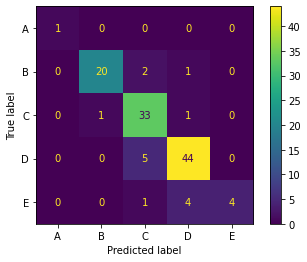

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test,y_pred)
plot_confusion_matrix(classifier, X_test, y_test)
plt.show()

#### The statistics obtained from the confusion matrix for the multiclass problem are calculated as follows:
- Precision = TP/(TP+FP)
- Recall = TP(TP+FN)

<img width="50%" height="50%" align="left" src="confusionmatrix2.png"> 


In [38]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       0.95      0.87      0.91        23
           C       0.80      0.94      0.87        35
           D       0.88      0.90      0.89        49
           E       1.00      0.44      0.62         9

    accuracy                           0.87       117
   macro avg       0.93      0.83      0.86       117
weighted avg       0.88      0.87      0.87       117



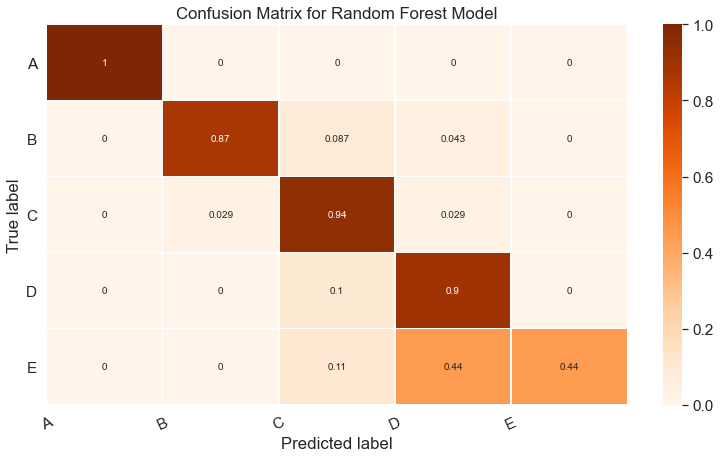

In [40]:
# Visualizing the confusion matrix with percentages
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Oranges, linewidths=0.2)

# Add labels to the plot
class_names = ['A','B', 'C', 'D', 'E']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

#### Log Loss 

In [41]:
from sklearn.metrics import log_loss

clf_probs = classifier.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)

score = log_loss(y_test, clf_probs, labels=['A','B','C','D', 'E'])
cal_score = log_loss(y_test, cal_clf_probs, labels=['A','B','C','D', 'E'])

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 0.664
 * calibrated classifier: 0.413


According to this [resource](https://medium.com/@fzammito/whats-considered-a-good-log-loss-in-machine-learning-a529d400632d), a relatively high log-loss (significantly larger than 0) is acceptable for the case of a multiclass problem. The present one can be considered as very solid.

#### Roc/Auc Score

In [42]:
roc_auc_score(y, cal_clf.predict_proba(X), multi_class='ovr')

0.6044079588529704

According to the available resources, an Roc/Auc score of 1 would be the best score. The present one is a little higher than the others.

#### Key conclusions. 

##### The results are solid. Even though the "class_weight='balanced'" has been used to get unexpected predictions, the results roughly followed the population's distribution. A middle to high number of winning bids (corresponding to the classes B, C, and D) has been predicted. 